/usr/local/lib/python3.12/dist-packages/scipy/stats/_stats_py.py:6316: RuntimeWarning: invalid value encountered in scalar divide
  svar = ((n1 - 1) * v1 + (n2 - 1) * v2) / df
/usr/local/lib/python3.12/dist-packages/scipy/_lib/deprecation.py:234: SmallSampleWarning: After omitting NaNs, one or more axis-slices of one or more sample arguments is too small; corresponding elements of returned arrays will be NaN. See documentation for sample size requirements.
  return f(*args, **kwargs)


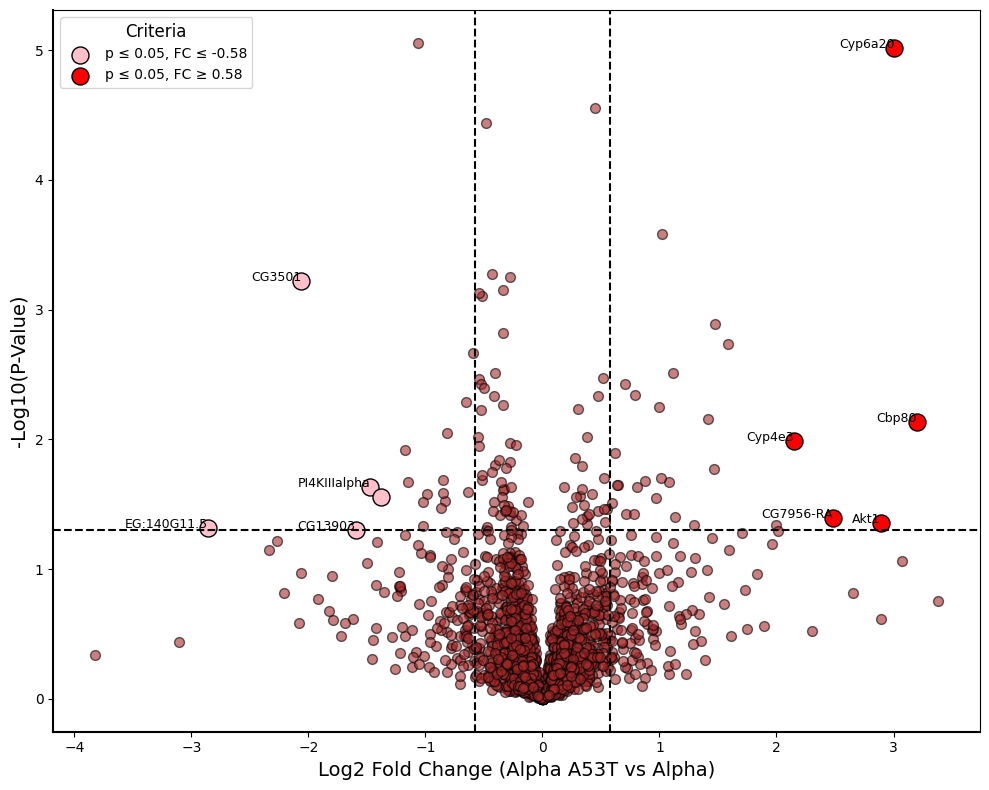

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import re

url = 'https://raw.githubusercontent.com/Olagrace837/Final-Project/refs/heads/main/Alpha53T%20and%20Alpha%20with%20genes.csv'
# Assuming the first column contains gene names and should be used as the index
df = pd.read_csv(url, index_col=0)
# Name the index column 'Gene names' and convert it into a regular column
df.index.name = 'Gene names'
df = df.reset_index()

# Clean column names by stripping whitespace
df.columns = df.columns.str.strip()

# Dynamically identify control and KO columns based on common patterns.
# Assuming 'Alpha ' (without 'A53T') columns are controls, and 'Alpha A53T_' columns are knockouts.
# Using regex to capture columns matching the pattern 'Alpha _day_X_Y' or 'Alpha A53T_day_X_Y'
control_cols = sorted([col for col in df.columns if re.match(r'^Alpha _day_\d+_\d+$', col)])
ko_cols = sorted([col for col in df.columns if re.match(r'^Alpha A53T_day_\d+_\d+$', col)])

# If initial regex matching fails, try a more lenient approach, or print df.columns to inspect
if not control_cols:
    print("Attempting broader search for control columns...")
    control_cols = sorted([col for col in df.columns if 'Alpha ' in col and 'A53T' not in col and 'day' in col])
if not ko_cols:
    print("Attempting broader search for KO columns...")
    ko_cols = sorted([col for col in df.columns if 'Alpha A53T_' in col and 'day' in col])


if not control_cols:
    print(f"Error: No control columns found matching expected patterns. Identified columns: {df.columns.tolist()}")
    raise ValueError("Control columns not identified. Please check DataFrame column names and patterns.")
if not ko_cols:
    print(f"Error: No KO columns found matching expected patterns. Identified columns: {df.columns.tolist()}")
    raise ValueError("KO columns not identified. Please check DataFrame column names and patterns.")

numeric_cols = control_cols + ko_cols

for col in numeric_cols:
    # Replace '#VALUE!' string with NaN before converting to numeric
    df[col] = df[col].replace('#VALUE!', np.nan)
    df[col] = pd.to_numeric(df[col], errors='coerce')

df.head()

# Calculate mean for WT and DM replicates
df['WT_Mean'] = df[control_cols].mean(axis=1)
df['hnox_Mean'] = df[ko_cols].mean(axis=1)

# Calculate log2 fold-change
#df['Log2_FC'] = np.log2(df['hnox_Mean'] / df['WT_Mean'].replace(0, np.nan)) (the values are already log transformed, so i have not used this)
df['Log2_FC'] = (df['hnox_Mean'] - df['WT_Mean'].replace(0, np.nan))


# Perform t-tests (two-sample assuming equal variance)
# Ensure all values are numeric for t-test
t_stats, p_values = ttest_ind(
    df[control_cols].values,
    df[ko_cols].values,
    axis=1, nan_policy='omit'
)

# Add p-values and -log10(p-values) to the DataFrame
df['P_Value'] = p_values
df['MinusLog10_P'] = -np.log10(df['P_Value'])

# --- MODIFIED: Filter top 5 significant genes from both sides more explicitly ---
# Define significance and fold change thresholds for determining "top" genes
p_value_threshold = 0.05 # For statistical significance
log2_fc_threshold_abs = 0.58 # For biological significance (absolute value)

# Filter for genes that are statistically significant
significant_df = df[df['P_Value'] < p_value_threshold]

# Get the top 5 upregulated genes among significant ones (with positive Log2_FC above threshold)
top_5_up = significant_df[significant_df['Log2_FC'] >= log2_fc_threshold_abs].nlargest(5, 'Log2_FC')

# Get the top 5 downregulated genes among significant ones (with negative Log2_FC below threshold)
top_5_down = significant_df[significant_df['Log2_FC'] <= -log2_fc_threshold_abs].nsmallest(5, 'Log2_FC')

# Combine these to form the top_genes for labeling on the plot
top_genes = pd.concat([top_5_up, top_5_down]).drop_duplicates(subset=['Gene names']) # Corrected to use 'Gene names'
# --- END MODIFIED SECTION ---

# Separate significant genes for coloring (these now filter from the new 'top_genes')
left_candidates = top_genes[top_genes['Log2_FC'] < -0.58]
right_candidates = top_genes[top_genes['Log2_FC'] >= 0.58]


# Create the volcano plot
plt.figure(figsize=(10, 8))
plt.scatter(df['Log2_FC'], df['MinusLog10_P'], alpha=0.6, edgecolor='black', marker='o', s=50, color='brown') # Changed color to brown

# Highlight significant genes
plt.scatter(left_candidates['Log2_FC'], left_candidates['MinusLog10_P'], color='pink', s=150, edgecolor='black', marker='o', label='p ≤ 0.05, FC ≤ -0.58') # Changed color to pink
plt.scatter(right_candidates['Log2_FC'], right_candidates['MinusLog10_P'], color='red', s=150, edgecolor='black', marker='o', label='p ≤ 0.05, FC ≥ 0.58') # Changed color to red

# Add gene labels
gene_name_col = 'Gene names'
if gene_name_col not in df.columns:
    print("Warning: 'Gene names' column not found for labeling.")
else:
    # Filter out entries that are not valid gene names (e.g., NaN, '#VALUE!', numeric strings)
    def is_valid_gene_name(name):
        if pd.isna(name): # Check for numpy NaN
            return False
        name_str = str(name).strip()
        if name_str == '' or name_str == '#VALUE!':
            return False
        try:
            float(name_str) # If it can be converted to a float, it's likely not a gene name
            return False
        except ValueError:
            pass
        return True

    top_genes_for_labeling = top_genes[top_genes[gene_name_col].apply(is_valid_gene_name)]

    for _, row in top_genes_for_labeling.iterrows():
        plt.text(row['Log2_FC'], row['MinusLog10_P'], row[gene_name_col], fontsize=9, ha='right')

# Add reference lines
plt.axhline(-np.log10(0.05), color='black', linestyle='--')
plt.axvline(0.58, color='black', linestyle='--')
plt.axvline(-0.58, color='black', linestyle='--')

# Add a border
plt.gca().spines['top'].set_visible(True)
plt.gca().spines['right'].set_visible(True)
plt.gca().spines['left'].set_linewidth(1.5)
plt.gca().spines['bottom'].set_linewidth(1.5)

# Update axis labels and add legend
plt.xlabel('Log2 Fold Change (Alpha A53T vs Alpha)', fontsize=14)
plt.ylabel('-Log10(P-Value)', fontsize=14)
plt.legend(loc='best', fontsize=10, title='Criteria', title_fontsize=12)
plt.tight_layout()
# Show the plot
plt.show()

In [41]:
display(df.head())

,Gene names,Alpha A53T_day_1_1,Alpha A53T_day_1_2,Alpha A53T_day_10_1,Alpha A53T_day_10_2,Alpha A53T_day_30_1,Alpha A53T_day_30_2,Alpha _day_1_1,Alpha _day_1_2,Alpha _day_10_1,...,WT_Mean_day10,hnox_Mean_day10,Log2_FC_day10,P_Value_day10,MinusLog10_P_day10,WT_Mean_day30,hnox_Mean_day30,Log2_FC_day30,P_Value_day30,MinusLog10_P_day30
0,NaN,-0.991943,NaN,-1.464066,-1.939095,NaN,-2.285038,-1.144903,NaN,NaN,...,NaN,-1.701581,NaN,1.000000,-0.000000,-1.018458,-2.285038,-1.266580,0.299624,0.523423
1,dnc,-1.187871,NaN,-2.388733,-2.078198,NaN,-2.181804,-1.258322,-1.648779,-1.381122,...,-1.749455,-2.233466,-0.484011,0.349615,0.456410,-2.285280,-2.181804,0.103476,0.776240,0.110004
2,NaN,-1.456999,NaN,-2.380521,-2.714633,-2.430820,-2.072483,NaN,NaN,-0.444125,...,-1.155623,-2.547577,-1.391955,0.197132,0.705243,-0.189960,-2.251651,-2.061691,0.095111,1.021769
3,Marf,-0.804048,-1.256528,-1.649095,-1.301017,NaN,-1.980796,-0.954641,-1.284686,-1.517296,...,-1.838056,-1.475056,0.363000,0.424695,0.371923,-0.765223,-1.980796,-1.215573,0.199654,0.699723
4,Rh4,NaN,NaN,-0.967448,-1.357825,-0.627471,-1.930765,NaN,-0.369930,NaN,...,NaN,-1.162636,NaN,1.000000,-0.000000,-3.020692,-1.279118,1.741573,0.366074,0.436432


In [19]:
print(df.columns.tolist())

['Alpha A53T_day_1_1', 'Alpha A53T_day_1_2', 'Alpha A53T_day_10_1', 'Alpha A53T_day_10_2', 'Alpha A53T_day_30_1', 'Alpha A53T_day_30_2', 'Alpha _day_1_1', 'Alpha _day_1_2', 'Alpha _day_10_1', 'Alpha _day_10_2', 'Alpha _day_30_1', 'Alpha _day_30_2']


In [43]:
print("\nTop 5 Upregulated Genes:")
display(top_genes[top_genes['Log2_FC'] > 0].nlargest(5, 'Log2_FC')[['Gene names', 'Log2_FC']])

print("\nTop 5 Downregulated Genes:")
display(top_genes[top_genes['Log2_FC'] < 0].nsmallest(5, 'Log2_FC')[['Gene names', 'Log2_FC']])


Top 5 Upregulated Genes:


,Gene names,Log2_FC
560,Cbp80,3.197294
4109,Cyp6a20,3.006776
1058,Akt1,2.891661
537,CG7956-RA,2.481875
1659,Cyp4e3,2.146424



Top 5 Downregulated Genes:


,Gene names,Log2_FC
1250,EG:140G11.5,-2.861359
2127,CG3501,-2.059466
2086,CG13903,-1.596329
2345,PI4KIIIalpha,-1.472968
2,NaN,-1.377356


In [63]:
day1_control_cols = sorted([col for col in control_cols if '_day_1_' in col and 'day_10' not in col])
day1_ko_cols = sorted([col for col in ko_cols if '_day_1_' in col and 'day_10' not in col])

print(f"Day 1 Control Columns: {day1_control_cols}")
print(f"Day 1 A53T Columns: {day1_ko_cols}")

Day 1 Control Columns: ['Alpha _day_1_1', 'Alpha _day_1_2']
Day 1 A53T Columns: ['Alpha A53T_day_1_1', 'Alpha A53T_day_1_2']


In [71]:
print("\nDay 1 Analysis Data:")
display(df_day1_analysis)



Day 1 Analysis Data:


,Gene names,WT_Mean_day1,hnox_Mean_day1,Log2_FC_day1,P_Value_day1,MinusLog10_P_day1
0,NaN,-1.144903,-0.991943,0.152960,1.000000,-0.000000
1,dnc,-1.453550,-1.187871,0.265679,0.576039,0.239548
2,NaN,NaN,-1.456999,NaN,1.000000,-0.000000
3,Marf,-1.119664,-1.030288,0.089376,0.779854,0.107987
4,Rh4,-0.369930,NaN,NaN,1.000000,-0.000000


In [72]:
print("\nDay 10 Analysis Data:")
display(df_day10_analysis)



Day 10 Analysis Data:


,Gene names,WT_Mean_day10,hnox_Mean_day10,Log2_FC_day10,P_Value_day10,MinusLog10_P_day10
0,NaN,NaN,-1.701581,NaN,1.000000,-0.000000
1,dnc,-1.749455,-2.233466,-0.484011,0.349615,0.456410
2,NaN,-1.155623,-2.547577,-1.391955,0.197132,0.705243
3,Marf,-1.838056,-1.475056,0.363000,0.424695,0.371923
4,Rh4,NaN,-1.162636,NaN,1.000000,-0.000000


In [73]:
print("\nDay 30 Analysis Data:")
display(df_day30_analysis)



Day 30 Analysis Data:


,Gene names,WT_Mean_day30,hnox_Mean_day30,Log2_FC_day30,P_Value_day30,MinusLog10_P_day30
0,NaN,-1.018458,-2.285038,-1.266580,0.299624,0.523423
1,dnc,-2.285280,-2.181804,0.103476,0.776240,0.110004
2,NaN,-0.189960,-2.251651,-2.061691,0.095111,1.021769
3,Marf,-0.765223,-1.980796,-1.215573,0.199654,0.699723
4,Rh4,-3.020692,-1.279118,1.741573,0.366074,0.436432


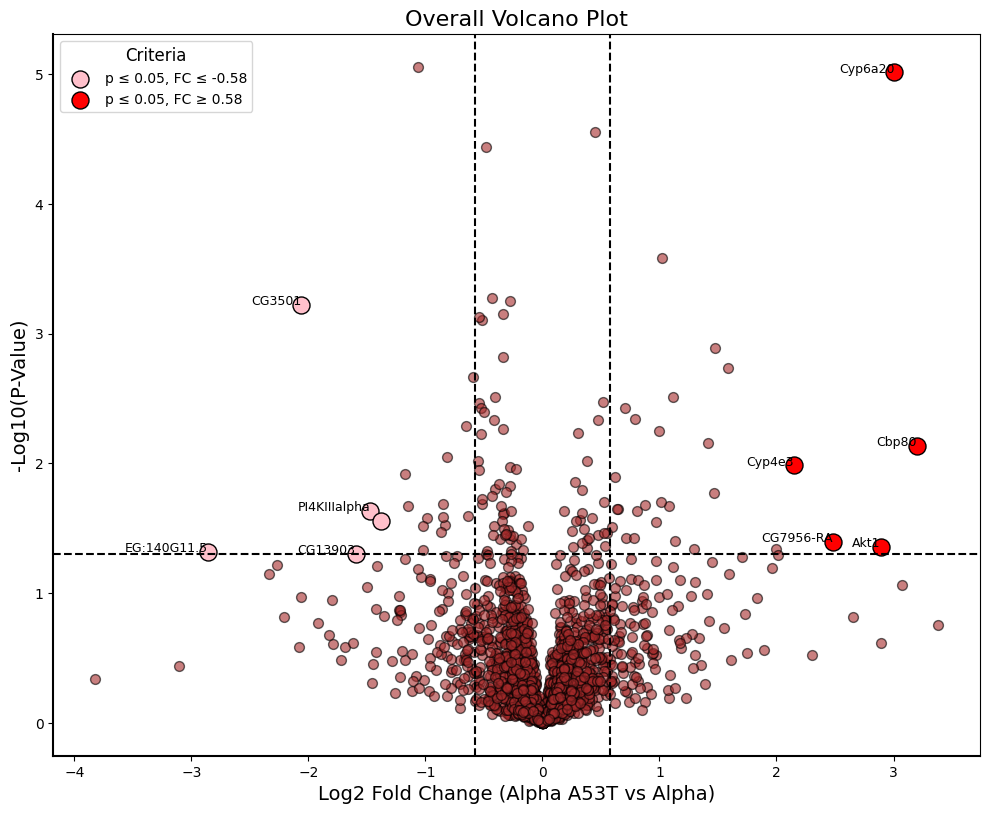

In [74]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

p_value_threshold = 0.05
log2_fc_threshold_abs = 0.58

significant_df = df[df['P_Value'] < p_value_threshold]
top_5_up = significant_df[significant_df['Log2_FC'] >= log2_fc_threshold_abs].nlargest(5, 'Log2_FC')
top_5_down = significant_df[significant_df['Log2_FC'] <= -log2_fc_threshold_abs].nsmallest(5, 'Log2_FC')
top_genes = pd.concat([top_5_up, top_5_down]).drop_duplicates(subset=['Gene names'])

left_candidates = top_genes[top_genes['Log2_FC'] < -0.58]
right_candidates = top_genes[top_genes['Log2_FC'] >= 0.58]

plt.figure(figsize=(10, 8))
plt.scatter(df['Log2_FC'], df['MinusLog10_P'], alpha=0.6, edgecolor='black', marker='o', s=50, color='brown')

plt.scatter(left_candidates['Log2_FC'], left_candidates['MinusLog10_P'], color='pink', s=150, edgecolor='black', marker='o', label='p ≤ 0.05, FC ≤ -0.58')
plt.scatter(right_candidates['Log2_FC'], right_candidates['MinusLog10_P'], color='red', s=150, edgecolor='black', marker='o', label='p ≤ 0.05, FC ≥ 0.58')

gene_name_col = 'Gene names'
def is_valid_gene_name(name):
    if pd.isna(name):
        return False
    name_str = str(name).strip()
    if name_str == '' or name_str == '#VALUE!':
        return False
    try:
        float(name_str)
        return False
    except ValueError:
        pass
    return True

top_genes_for_labeling = top_genes[top_genes[gene_name_col].apply(is_valid_gene_name)]

for _, row in top_genes_for_labeling.iterrows():
    plt.text(row['Log2_FC'], row['MinusLog10_P'], row[gene_name_col], fontsize=9, ha='right')

plt.axhline(-np.log10(0.05), color='black', linestyle='--')
plt.axvline(0.58, color='black', linestyle='--')
plt.axvline(-0.58, color='black', linestyle='--')

plt.gca().spines['top'].set_visible(True)
plt.gca().spines['right'].set_visible(True)
plt.gca().spines['left'].set_linewidth(1.5)
plt.gca().spines['bottom'].set_linewidth(1.5)

plt.xlabel('Log2 Fold Change (Alpha A53T vs Alpha)', fontsize=14)
plt.ylabel('-Log10(P-Value)', fontsize=14)
plt.legend(loc='best', fontsize=10, title='Criteria', title_fontsize=12)
plt.tight_layout()
plt.title('Overall Volcano Plot', fontsize=16)
plt.show()

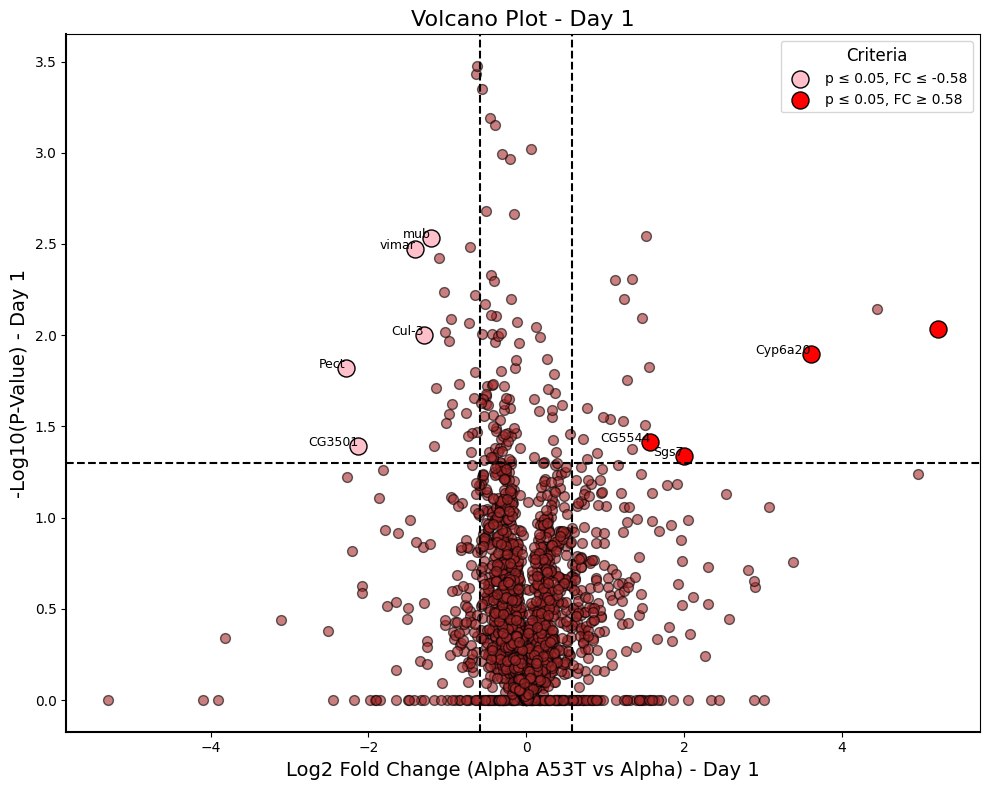

In [76]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

p_value_threshold_day1 = 0.05
log2_fc_threshold_abs_day1 = 0.58

significant_df_day1 = df[df['P_Value_day1'] < p_value_threshold_day1].copy()
top_5_up_day1 = significant_df_day1[significant_df_day1['Log2_FC_day1'] >= log2_fc_threshold_abs_day1].nlargest(5, 'Log2_FC_day1')
top_5_down_day1 = significant_df_day1[significant_df_day1['Log2_FC_day1'] <= -log2_fc_threshold_abs_day1].nsmallest(5, 'Log2_FC_day1')
top_genes_day1 = pd.concat([top_5_up_day1, top_5_down_day1]).drop_duplicates(subset=['Gene names'])

left_candidates_day1 = top_genes_day1[top_genes_day1['Log2_FC_day1'] < -log2_fc_threshold_abs_day1]
right_candidates_day1 = top_genes_day1[top_genes_day1['Log2_FC_day1'] >= log2_fc_threshold_abs_day1]

plt.figure(figsize=(10, 8))
plt.scatter(df['Log2_FC_day1'], df['MinusLog10_P_day1'], alpha=0.6, edgecolor='black', marker='o', s=50, color='brown')

plt.scatter(left_candidates_day1['Log2_FC_day1'], left_candidates_day1['MinusLog10_P_day1'], color='pink', s=150, edgecolor='black', marker='o', label=f'p ≤ {p_value_threshold_day1}, FC ≤ -{log2_fc_threshold_abs_day1}')
plt.scatter(right_candidates_day1['Log2_FC_day1'], right_candidates_day1['MinusLog10_P_day1'], color='red', s=150, edgecolor='black', marker='o', label=f'p ≤ {p_value_threshold_day1}, FC ≥ {log2_fc_threshold_abs_day1}')

gene_name_col = 'Gene names'
def is_valid_gene_name(name):
    if pd.isna(name):
        return False
    name_str = str(name).strip()
    if name_str == '' or name_str == '#VALUE!':
        return False
    try:
        float(name_str)
        return False
    except ValueError:
        pass
    return True

top_genes_for_labeling_day1 = top_genes_day1[top_genes_day1[gene_name_col].apply(is_valid_gene_name)]

for _, row in top_genes_for_labeling_day1.iterrows():
    plt.text(row['Log2_FC_day1'], row['MinusLog10_P_day1'], row[gene_name_col], fontsize=9, ha='right')

plt.axhline(-np.log10(p_value_threshold_day1), color='black', linestyle='--')
plt.axvline(log2_fc_threshold_abs_day1, color='black', linestyle='--')
plt.axvline(-log2_fc_threshold_abs_day1, color='black', linestyle='--')

plt.gca().spines['top'].set_visible(True)
plt.gca().spines['right'].set_visible(True)
plt.gca().spines['left'].set_linewidth(1.5)
plt.gca().spines['bottom'].set_linewidth(1.5)

plt.xlabel('Log2 Fold Change (Alpha A53T vs Alpha) - Day 1', fontsize=14)
plt.ylabel('-Log10(P-Value) - Day 1', fontsize=14)
plt.title('Volcano Plot - Day 1', fontsize=16)
plt.legend(loc='best', fontsize=10, title='Criteria', title_fontsize=12)
plt.tight_layout()
plt.show()

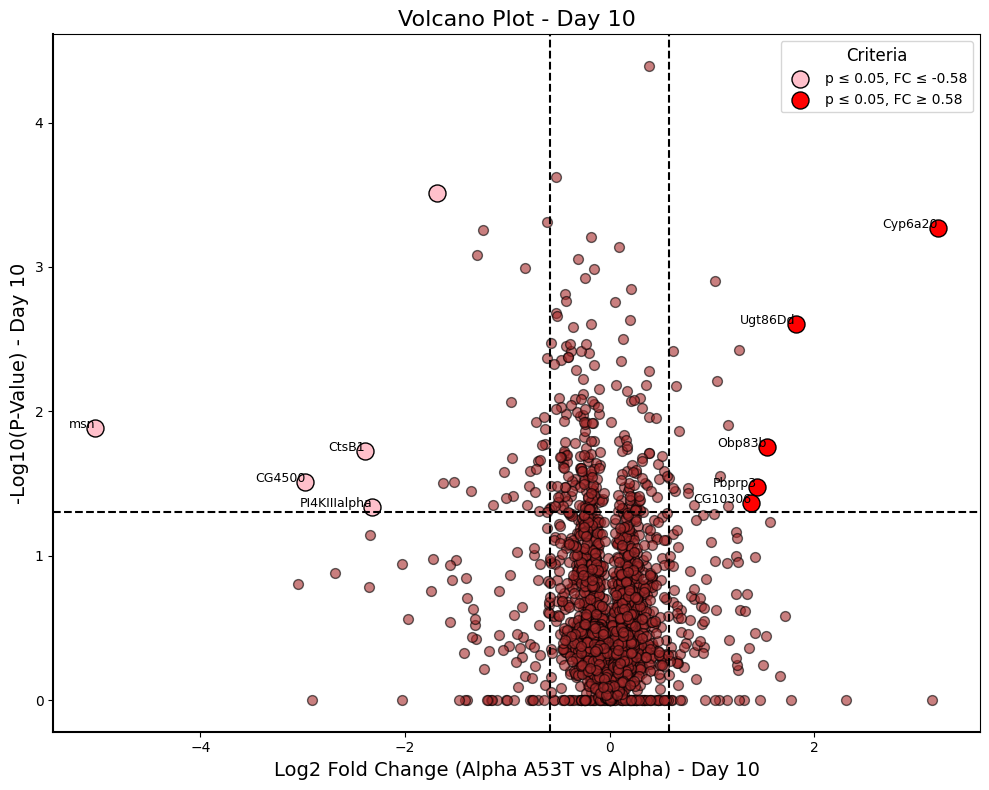

In [77]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

p_value_threshold_day10 = 0.05
log2_fc_threshold_abs_day10 = 0.58

significant_df_day10 = df[df['P_Value_day10'] < p_value_threshold_day10].copy()
top_5_up_day10 = significant_df_day10[significant_df_day10['Log2_FC_day10'] >= log2_fc_threshold_abs_day10].nlargest(5, 'Log2_FC_day10')
top_5_down_day10 = significant_df_day10[significant_df_day10['Log2_FC_day10'] <= -log2_fc_threshold_abs_day10].nsmallest(5, 'Log2_FC_day10')
top_genes_day10 = pd.concat([top_5_up_day10, top_5_down_day10]).drop_duplicates(subset=['Gene names'])

left_candidates_day10 = top_genes_day10[top_genes_day10['Log2_FC_day10'] < -log2_fc_threshold_abs_day10]
right_candidates_day10 = top_genes_day10[top_genes_day10['Log2_FC_day10'] >= log2_fc_threshold_abs_day10]

plt.figure(figsize=(10, 8))
plt.scatter(df['Log2_FC_day10'], df['MinusLog10_P_day10'], alpha=0.6, edgecolor='black', marker='o', s=50, color='brown')

plt.scatter(left_candidates_day10['Log2_FC_day10'], left_candidates_day10['MinusLog10_P_day10'], color='pink', s=150, edgecolor='black', marker='o', label=f'p ≤ {p_value_threshold_day10}, FC ≤ -{log2_fc_threshold_abs_day10}')
plt.scatter(right_candidates_day10['Log2_FC_day10'], right_candidates_day10['MinusLog10_P_day10'], color='red', s=150, edgecolor='black', marker='o', label=f'p ≤ {p_value_threshold_day10}, FC ≥ {log2_fc_threshold_abs_day10}')

gene_name_col = 'Gene names'
def is_valid_gene_name(name):
    if pd.isna(name):
        return False
    name_str = str(name).strip()
    if name_str == '' or name_str == '#VALUE!':
        return False
    try:
        float(name_str)
        return False
    except ValueError:
        pass
    return True

top_genes_for_labeling_day10 = top_genes_day10[top_genes_day10[gene_name_col].apply(is_valid_gene_name)]

for _, row in top_genes_for_labeling_day10.iterrows():
    plt.text(row['Log2_FC_day10'], row['MinusLog10_P_day10'], row[gene_name_col], fontsize=9, ha='right')

plt.axhline(-np.log10(p_value_threshold_day10), color='black', linestyle='--')
plt.axvline(log2_fc_threshold_abs_day10, color='black', linestyle='--')
plt.axvline(-log2_fc_threshold_abs_day10, color='black', linestyle='--')

plt.gca().spines['top'].set_visible(True)
plt.gca().spines['right'].set_visible(True)
plt.gca().spines['left'].set_linewidth(1.5)
plt.gca().spines['bottom'].set_linewidth(1.5)

plt.xlabel('Log2 Fold Change (Alpha A53T vs Alpha) - Day 10', fontsize=14)
plt.ylabel('-Log10(P-Value) - Day 10', fontsize=14)
plt.title('Volcano Plot - Day 10', fontsize=16)
plt.legend(loc='best', fontsize=10, title='Criteria', title_fontsize=12)
plt.tight_layout()
plt.show()

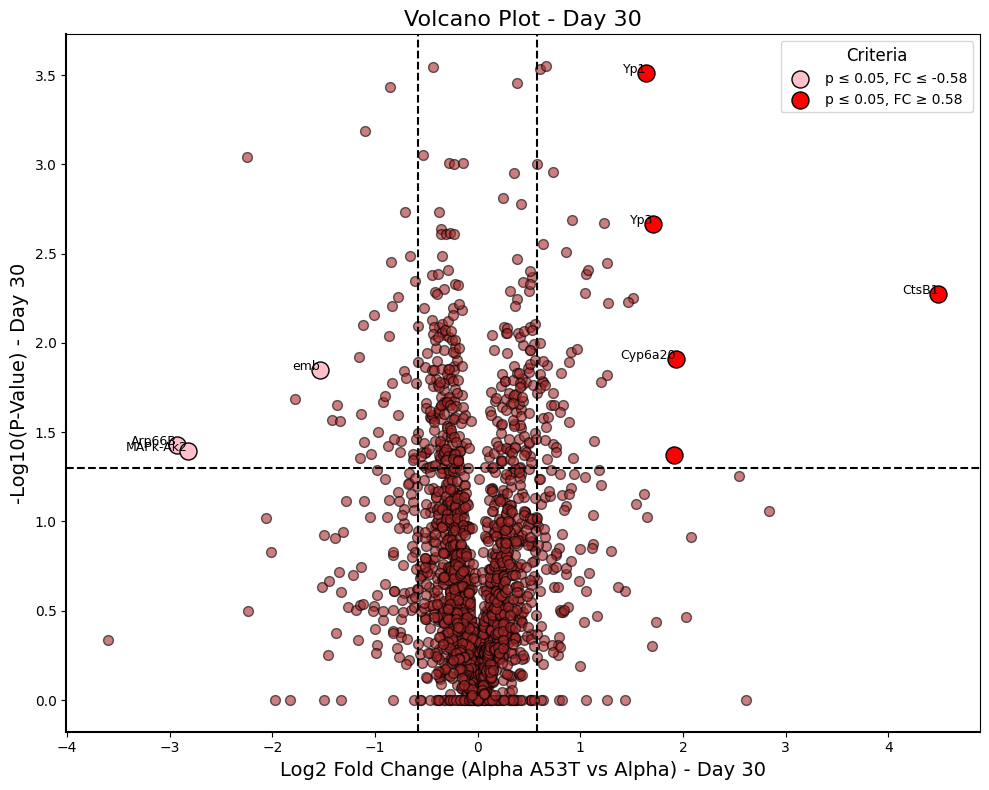

In [78]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

p_value_threshold_day30 = 0.05
log2_fc_threshold_abs_day30 = 0.58

significant_df_day30 = df[df['P_Value_day30'] < p_value_threshold_day30].copy()
top_5_up_day30 = significant_df_day30[significant_df_day30['Log2_FC_day30'] >= log2_fc_threshold_abs_day30].nlargest(5, 'Log2_FC_day30')
top_5_down_day30 = significant_df_day30[significant_df_day30['Log2_FC_day30'] <= -log2_fc_threshold_abs_day30].nsmallest(5, 'Log2_FC_day30')
top_genes_day30 = pd.concat([top_5_up_day30, top_5_down_day30]).drop_duplicates(subset=['Gene names'])

left_candidates_day30 = top_genes_day30[top_genes_day30['Log2_FC_day30'] < -log2_fc_threshold_abs_day30]
right_candidates_day30 = top_genes_day30[top_genes_day30['Log2_FC_day30'] >= log2_fc_threshold_abs_day30]

plt.figure(figsize=(10, 8))
plt.scatter(df['Log2_FC_day30'], df['MinusLog10_P_day30'], alpha=0.6, edgecolor='black', marker='o', s=50, color='brown')

plt.scatter(left_candidates_day30['Log2_FC_day30'], left_candidates_day30['MinusLog10_P_day30'], color='pink', s=150, edgecolor='black', marker='o', label=f'p ≤ {p_value_threshold_day30}, FC ≤ -{log2_fc_threshold_abs_day30}')
plt.scatter(right_candidates_day30['Log2_FC_day30'], right_candidates_day30['MinusLog10_P_day30'], color='red', s=150, edgecolor='black', marker='o', label=f'p ≤ {p_value_threshold_day30}, FC ≥ {log2_fc_threshold_abs_day30}')

gene_name_col = 'Gene names'
def is_valid_gene_name(name):
    if pd.isna(name):
        return False
    name_str = str(name).strip()
    if name_str == '' or name_str == '#VALUE!':
        return False
    try:
        float(name_str)
        return False
    except ValueError:
        pass
    return True

top_genes_for_labeling_day30 = top_genes_day30[top_genes_day30[gene_name_col].apply(is_valid_gene_name)]

for _, row in top_genes_for_labeling_day30.iterrows():
    plt.text(row['Log2_FC_day30'], row['MinusLog10_P_day30'], row[gene_name_col], fontsize=9, ha='right')

plt.axhline(-np.log10(p_value_threshold_day30), color='black', linestyle='--')
plt.axvline(log2_fc_threshold_abs_day30, color='black', linestyle='--')
plt.axvline(-log2_fc_threshold_abs_day30, color='black', linestyle='--')

plt.gca().spines['top'].set_visible(True)
plt.gca().spines['right'].set_visible(True)
plt.gca().spines['left'].set_linewidth(1.5)
plt.gca().spines['bottom'].set_linewidth(1.5)

plt.xlabel('Log2 Fold Change (Alpha A53T vs Alpha) - Day 30', fontsize=14)
plt.ylabel('-Log10(P-Value) - Day 30', fontsize=14)
plt.title('Volcano Plot - Day 30', fontsize=16)
plt.legend(loc='best', fontsize=10, title='Criteria', title_fontsize=12)
plt.tight_layout()
plt.show()